# Reward shaping analysis

We import all things needed, starting by inserting the project path in order to have access to our custom-made `utils`.

_Note_: You can modify the project path as you wish, depending on the location of your project folder. For me, it's under `~/Projects`.

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

We can then import all the tools we are going to use

In [2]:
import numpy as np
from rlgym.utils import common_values
from utils.analysis.reward_functions import common, extra
from utils.analysis import plotting

We retrieve the arena positions of the arena `Triangulation` object, used for creating the plots

In [3]:
arena_positions = plotting.arena_positions

and begin with common rewards.

## Common rewards

The first type of common rewards in the list are ball to goal rewards.

### Ball2Goal

We set an arbitrary ball position.

In [4]:
ball_position = np.array([-1800, 1800, 400])

Ball to goal rewards are divided into three types:
- Distance to goal
- Distance from goal wall
- Ball to goal velocity

For each of them, we compute the reward function values across the field and proceed to plot them, along with the ball position and its reward, including the ball's linear velocity vector, whenever available.

#### Distance to goal

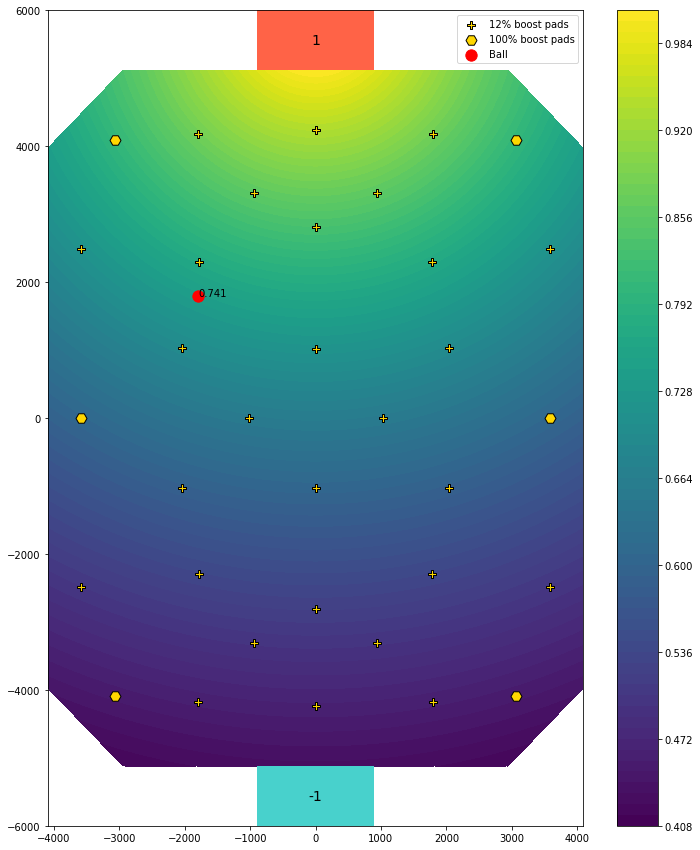

In [5]:
ball_zs = common.ball_goal.liu_dist_ball2goal(arena_positions)
plotting.arena_contour(ball_zs, ball_position=ball_position, annotate_ball=True)

####  Distance from goal wall

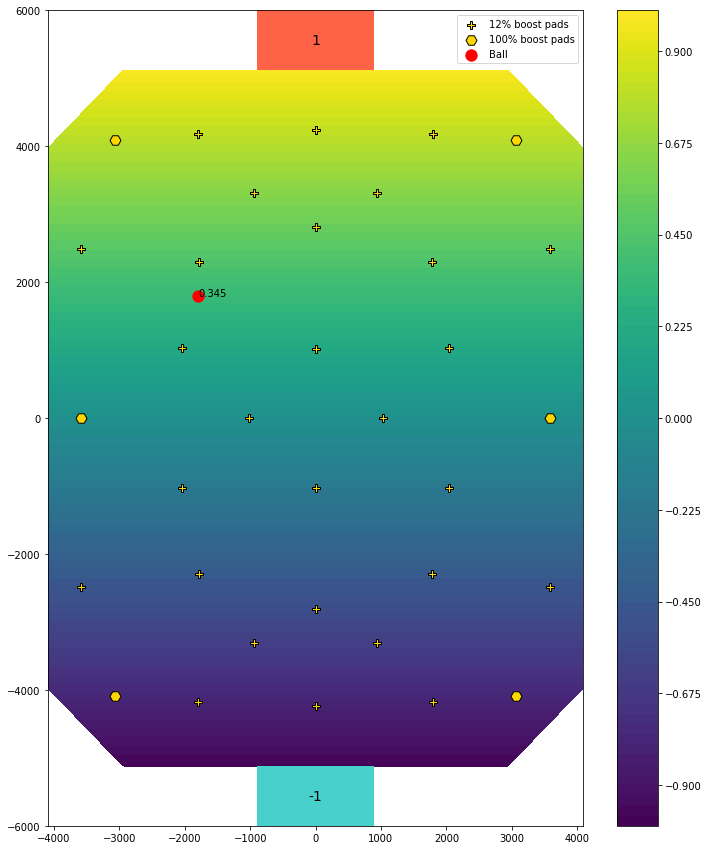

In [6]:
ball_zs = common.ball_goal.ball_y_coord(arena_positions)
plotting.arena_contour(ball_zs, ball_position=ball_position, annotate_ball=True)

#### Ball to goal velocity

You can play around with the values of ball linear velocity. First axis is the x axis (side to side), second is y (goal to goal), third is z (up/down).

**_Note_**: ball maximum linear velocity is 6000, any more is not reflective of the true reward.

In [7]:
ball_lin_velocity = np.array([0, 5999, -40], dtype=float)
ball_lin_velocity_vec_len = np.linalg.norm(ball_lin_velocity).item()
print("Ball linear velocity vector length is " + str(ball_lin_velocity_vec_len))
assert ball_lin_velocity_vec_len <= common_values.BALL_MAX_SPEED, "Max ball linear velocity vector length must be less than or equal to 6000"

Ball linear velocity vector length is 5999.13335407707


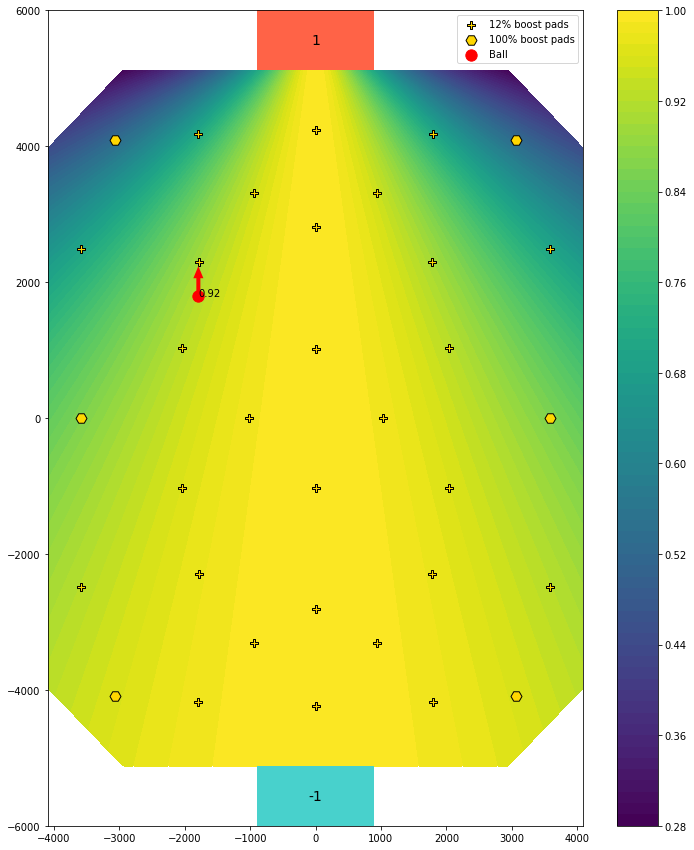

In [8]:
ball_zs = common.ball_goal.velocity_ball2goal(arena_positions, ball_lin_velocity)
plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       annotate_ball=True)

### Conditional

The second type of common rewards are conditional rewards. Those rewards happen only when a provided condition applies

#### Closest2ball

We set some arbitrary positions for the blue team

In [9]:
player_positions = np.array([[100, 400, 200], [1200, -600, 300]])

Out of the two players, the player with index 0 is the one that is closest, which is also visible with a simple plot.

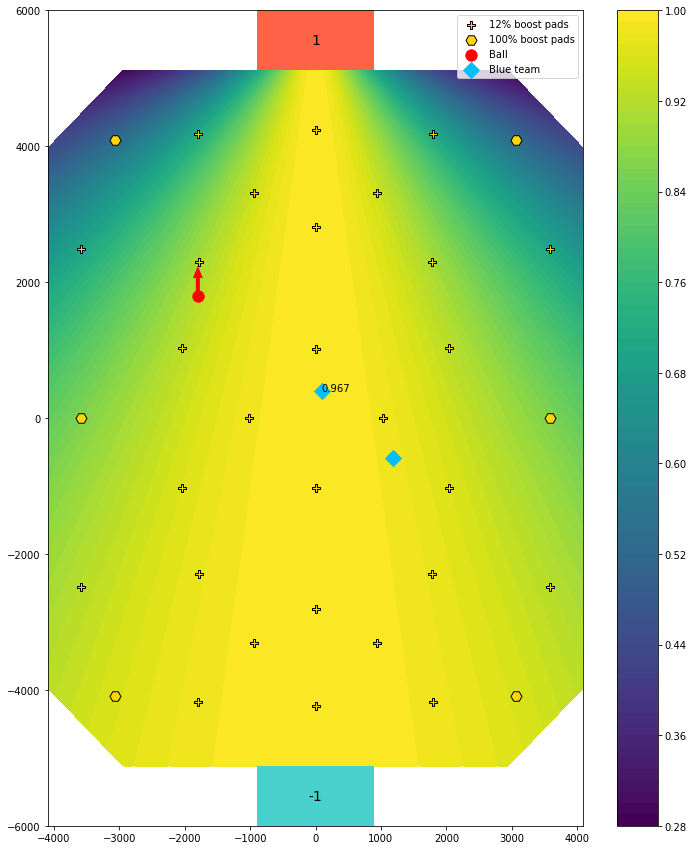

In [10]:
plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions)

And this is also verifiable through the conditional method

In [11]:
team_idx = [0, 0]
player_idx = 0
condition_args=(player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

In [12]:
team_idx = [0, 0]
player_idx = 1
condition_args=(player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

False

The same would also apply if all cars in the team were orange

In [13]:
team_idx = [1, 1]
player_idx = 0
condition_args=(player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

In [14]:
team_idx = [1, 1]
player_idx = 1
condition_args=(player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

False

In the conditions above, we consider distances among team cars only.

Therefore, if cars belonged to different teams, the condition would apply for both of them.

In [15]:
team_idx = [0, 1]
player_idx = 0
condition_args=(player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

In [16]:
team_idx = [0, 1]
player_idx = 1
condition_args=(player_positions, player_idx, team_idx, ball_position)
common.conditional("closest2ball", condition_args)

True

Now, let's consider two new teams.

In [17]:
blue_positions = np.array([[100, 400, 200], [1200, -600, 300]])
orange_positions = np.array([[-2000, 3500, 250], [2300, 3000, 50]])
player_positions = (blue_positions, orange_positions)

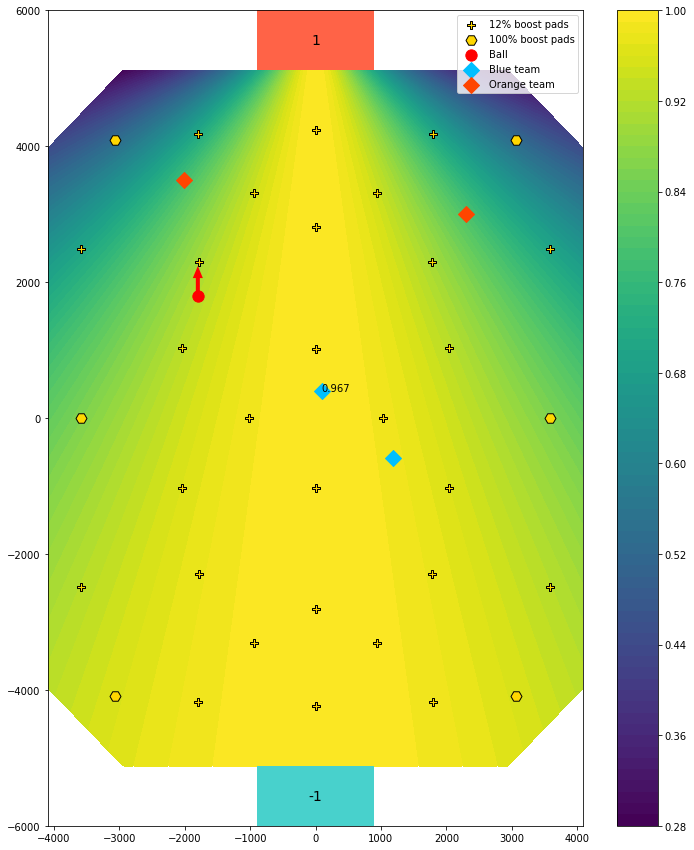

In [18]:
plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions)

Out of the two teams, the orange player with orange index 0 is closest to the ball.

In [19]:
team_idx = [0] * len(player_positions[0]) + [1] * len(player_positions[1])
team_only = False

In [20]:
# Blue team plus orange index
player_idx = len(player_positions[0]) + 0
# This time we concatenate because player_positions is a tuple
condition_args=(np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

True

In [21]:
player_idx = 0
condition_args=(np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

False

But supposing we consider teams only, blue player 0 is still found to be closest to the ball, along with orange player 0.

In [22]:
team_only = True

In [23]:
# Blue team plus orange index
player_idx = len(player_positions[0]) + 0
# This time we concatenate because player_positions is a tuple
condition_args=(np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

True

In [24]:
# Blue team plus orange index
player_idx = 0
# This time we concatenate because player_positions is a tuple
condition_args=(np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
common.conditional("closest2ball", condition_args)

True

To return to our original point, conditional rewards are given only when certain conditions apply, which we can examine using the `conditional` method.

So, in order to retrieve a specified reward, or a zero reward, all that remains is to multiply our reward array with the conditional boolean.

In [25]:
team_idx = [0] * len(player_positions[0]) + [1] * len(player_positions[1])
team_only = False
# Orange player 0
player_idx = len(player_positions[0]) + 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
condition_applies = common.conditional("closest2ball", condition_args)
condition_applies

True

In [27]:
conditional_zs = ball_zs * condition_applies

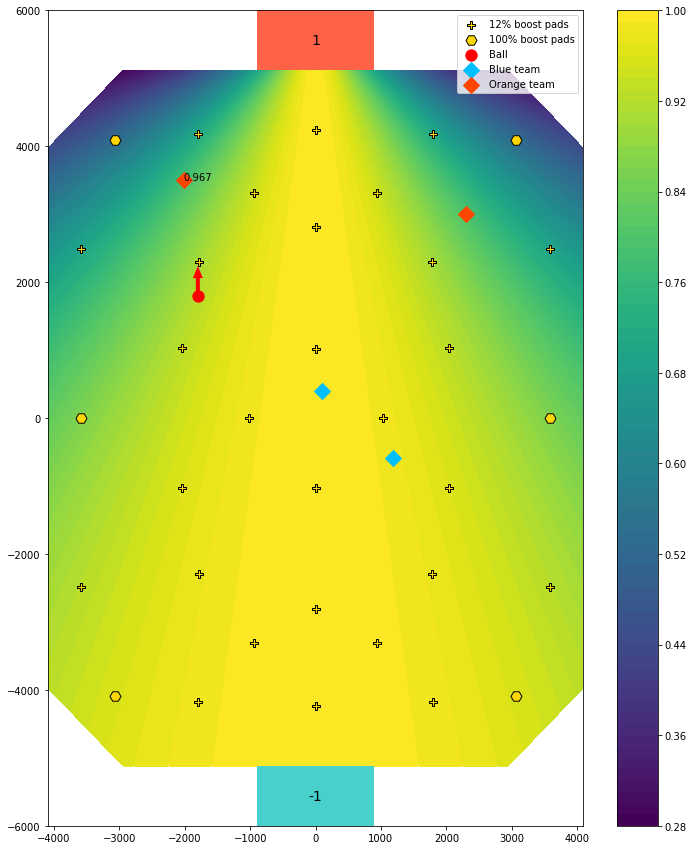

In [28]:
# This time we suppose the reward plot applies for orange player 0
plotting.arena_contour(conditional_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_idx=player_idx)  # Notice the plot as the player_idx changes

In [29]:
team_idx = [0] * len(player_positions[0]) + [1] * len(player_positions[1])
team_only = False
# Blue player 0
player_idx = 0
condition_args = (np.concatenate(player_positions), player_idx, team_idx, ball_position, team_only)
condition_applies = common.conditional("closest2ball", condition_args)
condition_applies

False

In [30]:
conditional_zs = ball_zs * condition_applies

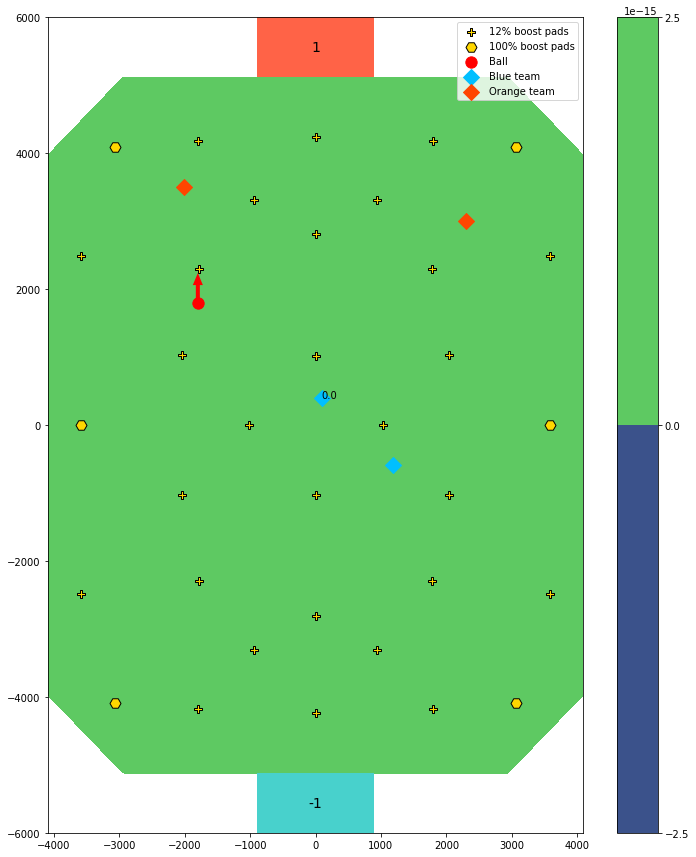

In [31]:
plotting.arena_contour(conditional_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_idx=player_idx)  # Notice the plot as the player_idx changes

#### Touched last

#### Behind ball

### Misc

### Player2ball

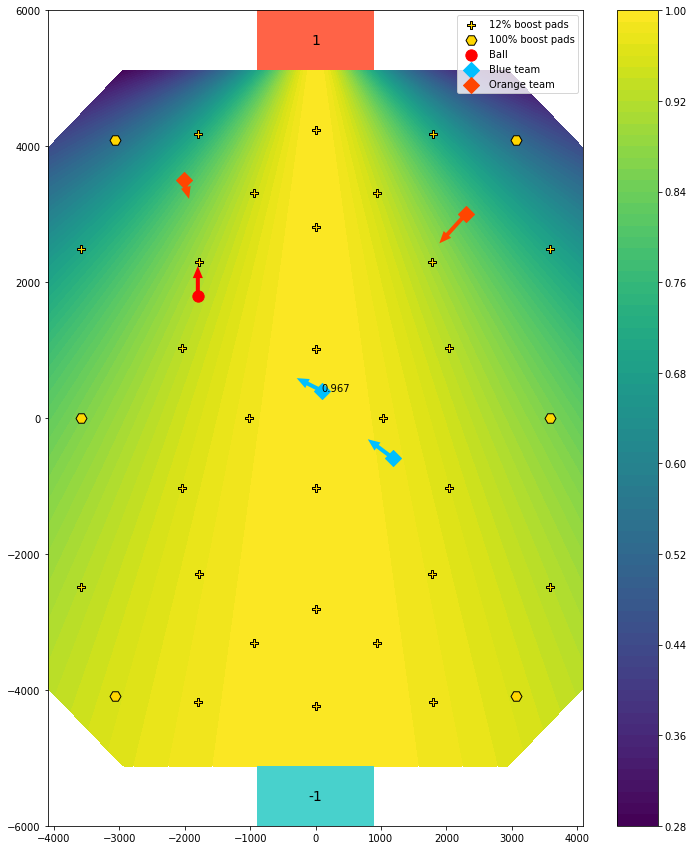

In [10]:
ball_position = np.array([-1800, 1800, 400])
ball_lin_velocity = np.array([0, 5999, -40], dtype=float)

# player_positions = np.array([[100, 400, 200]])
# player_lin_vels = np.array([[-1200, 600, 0]])

# player_positions = np.array([[100, 400, 200], [1200, -600, 300]])
# player_lin_vels = np.array([[-1200, 600, 0],[-1200, 900, 0]])

blue_positions = np.array([[100, 400, 200], [1200, -600, 300]])
orange_positions = np.array([[-2000, 3500, 250], [2300, 3000, 50]])
player_positions = (blue_positions, orange_positions)
blue_lin_vels = np.array([[-1200, 600, 0],[-1200, 900, 0]])
orange_lin_vels = np.array([[200, -700, 150],[-1000, -1100, 400]])
player_lin_vels = (blue_lin_vels, orange_lin_vels)

plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_lin_vels=player_lin_vels
                       )